In [ ]:
# Import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import asyncio
from sklearn import datasets
from tqdm import tqdm

# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nest_asyncio"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import nest_asyncio
import os

# Task definition

print('Data information')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

# Neural network definition
hidden_dim = 256
input_dim = 64
output_dim = 10
num_params = (1 + input_dim) * hidden_dim + (1 + hidden_dim) * output_dim
print(f'num_params={num_params}')


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def get_loss(model, data, labels):
    logits = model(data)
    log_probs = F.log_softmax(logits, dim=1)
    true_log_probs = log_probs.gather(1, labels.view(-1, 1))
    return -true_log_probs.mean()


def get_grad(model, data, labels):
    model.zero_grad()
    loss = get_loss(model, data, labels)
    loss.backward()
    return model.parameters()


def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=1)
    return (predicted_labels == labels).float().mean().item()


def train(model, x, y, lr=0.003, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = get_loss(model, x, y)
        loss.backward()
        optimizer.step()
    return model


# Test
mlp = MLP()
rand_params = torch.randn(num_params) * 0.01
mlp.fc1.weight.data = rand_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
mlp.fc1.bias.data = rand_params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
mlp.fc2.weight.data = rand_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
mlp.fc2.bias.data = rand_params[-output_dim:]


Data information
#samples=1797, image_size=torch.Size([64])
#odd_num_images=906
#even_num_images=891
num_params=19210


In [ ]:
print(images.shape)
logits = mlp(images)
loss = get_loss(mlp, images, labels)
acc = get_acc(logits, labels)
print(f'Random MLP: loss={loss.item():.4f}, acc={acc:.2f}')

# Train 2 seed MLPs
mlp1 = MLP()
mlp2 = MLP()

mlp1 = train(mlp1, odd_num_images, odd_num_labels)
mlp2 = train(mlp2, even_num_images, even_num_labels)

models = [mlp1, mlp2]
model_names = ['mlp1', 'mlp2']
for model, model_name in zip(models, model_names):
    for x, y, name in zip([odd_num_images, even_num_images, images], [odd_num_labels, even_num_labels, labels], ['d_odd', 'd_even', 'd0-9']):
        logits = model(x)
        acc = get_acc(logits, y)
        print(f'{model_name} acc@{name}={acc:.2f}')
    print('-' * 10)



torch.Size([1797, 64])
Random MLP: loss=2.3164, acc=0.09
mlp1 acc@d_odd=0.95
mlp1 acc@d_even=0.00
mlp1 acc@d0-9=0.48
----------
mlp2 acc@d_odd=0.00
mlp2 acc@d_even=0.97
mlp2 acc@d0-9=0.48
----------


 36%|███▌      | 9/25 [00:21<00:34,  2.16s/it]<ipython-input-34-3915373d2d70>:23: RuntimeWarning: coroutine 'zk_verify_merge' was never awaited
  return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)
100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


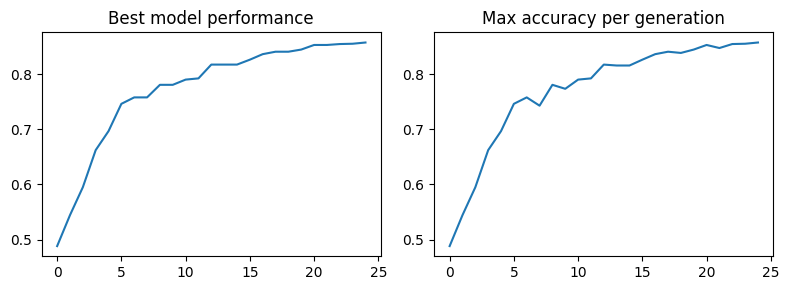

In [ ]:
# Evolutionary algorithm merging
#n_iter = 1000
n_iter = 25
mutation_std = 0.01
pop_size = 512
num_elite = 8
seed = 42

class Slerp(nn.Module):
    def __init__(self):
        super(Slerp, self).__init__()

    def forward(self, val, x, y):
      norm_x = F.normalize(x, dim=-1)
      norm_y = F.normalize(y, dim=-1)
      dot = torch.sum(norm_x * norm_y, dim=-1, keepdim=True)
      omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
      sin_omega = torch.sin(omega)
      scale_x = torch.sin((1.0 - val) * omega) / sin_omega
      scale_y = torch.sin(val * omega) / sin_omega
      lin_scale_x = 1.0 - val
      lin_scale_y = val
      return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)

'''
def slerp(val, x, y):
    norm_x = F.normalize(x, dim=-1)
    norm_y = F.normalize(y, dim=-1)
    dot = torch.sum(norm_x * norm_y, dim=-1, keepdim=True)
    omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
    sin_omega = torch.sin(omega)
    scale_x = torch.sin((1.0 - val) * omega) / sin_omega
    scale_y = torch.sin(val * omega) / sin_omega
    lin_scale_x = 1.0 - val
    lin_scale_y = val
    return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)
'''
slerp = Slerp()

'''
def crossover(parents):
    w = torch.rand(1)
    return slerp(w, parents[0], parents[1])
'''
async def zk_verify_merge(val, parent_1, parent_2):
    model_path = os.path.join('slerp.onnx')
    compiled_model_path = os.path.join('network.compiled')
    pk_path = os.path.join('test.pk')
    vk_path = os.path.join('test.vk')
    settings_path = os.path.join('settings.json')

    witness_path = os.path.join('witness.json')
    data_path = os.path.join('slerp_input.json')

    torch.onnx.export(
        slerp,                       # the model/module to be exported
        (val, parent_1, parent_2),                 # example inputs
        "slerp.onnx",                # the file name to save the ONNX model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=11,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['val', 'x', 'y'],  # input names
        output_names=['result'],        # output name
        dynamic_axes={'x': {0: 'batch_size'}, 'y': {0: 'batch_size'}, 'result': {0: 'batch_size'}}  # dynamic axis
    )
    input_data = {
        'val': val,        # scalar value
        'parent_1': parent_1,          # tensor to list
        'parent_2': parent_2           # tensor to list
    }
    with open("slerp_input.json", "w") as f:
        json.dump(input_data, f)

    py_run_args = ezkl.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

    res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
    assert res == True

    cal_path = os.path.join("calibration.json")

    data_array = (torch.rand(20, *shape, requires_grad=True).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_data = [data_array])

    # Serialize data into file:
    json.dump(data, open(cal_path, 'w'))


    await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs( settings_path)

    # now generate the witness file

    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)


    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK



    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,

        )

    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF


    proof_path = os.path.join('test.pf')

    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single",
        )

    print(res)
    assert os.path.isfile(proof_path)

    # VERIFY IT

    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,

        )

    assert res == True
    print("verified")
    return res

def crossover(parents):
    val = torch.rand(1)
    #asyncio.run(zk_verify_merge(val, parents[0], parents[1]))
    loop = asyncio.get_event_loop()
    verified = loop.create_task(zk_verify_merge(val, parents[0], parents[1]))
    print(verified)
    result = slerp(val, parents[0], parents[1])
    return result


def mutate(gene):
    noise = torch.randn(gene.shape) * mutation_std
    return gene + noise

def ask(elite_solutions):
    parents_indices = torch.randint(0, num_elite, (pop_size * 2,))
    parents = elite_solutions[parents_indices].view(pop_size, 2, -1)
    population = torch.stack([crossover(p) for p in parents])
    population = torch.stack([mutate(g) for g in population])
    return population

def get_flat_params(model):
    return torch.concatenate([p.view(-1) for p in model.parameters()])

def tell(population, scores):
    top_scores, top_indices = scores.topk(num_elite)
    #print('scores')
    #print(scores.shape)
    #print('elite solns')
    #print(elite_solutions.shape)
    #print('top inds')
    #print(top_indices)
    new_elites = population[top_indices]
    new_elites[-1] = get_flat_params(mlp1)
    new_elites[-2] = get_flat_params(mlp2)
    return new_elites

'''
def eval_params(params, x, y):
    model = MLP()
    # Load the model's parameters from the flattened params vector
    model.fc1.weight.data = params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
    model.fc1.bias.data = params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
    model.fc2.weight.data = params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
    model.fc2.bias.data = params[-output_dim:]
    logits = model(x)
    return get_acc(logits, y)
'''

'''
def eval_params(params, x, y):
    model = MLP()
    # Load the model's parameters from the flattened params vector, reshaping the weights
    model.fc1.weight.data = params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
    model.fc1.bias.data = params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
    model.fc2.weight.data = params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
    model.fc2.bias.data = params[-output_dim:]
    logits = model(x)
    return get_acc(logits, y)
'''
def eval_params(params, x, y):
    model = MLP()
    # Load the model's parameters from the flattened params vector, reshaping the weights
    model.fc1.weight.data = params[:hidden_dim * input_dim].view(hidden_dim, input_dim)

    model.fc1.bias.data = params[(hidden_dim * input_dim):(hidden_dim * input_dim + hidden_dim)]

    model.fc2.weight.data = params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)

    model.fc2.bias.data = params[-output_dim:]

    # Reshape the input data to match the expected input size of the model
    x_reshaped = x.view(-1, input_dim)  # Reshape to [batch_size, input_dim]

    logits = model(x_reshaped)  # Pass the reshaped input to the model
    return get_acc(logits, y)

# Initialize the elites with seed models
mlp1_param = torch.concatenate([mlp1.state_dict()['fc1.weight'].view(-1), mlp1.state_dict()['fc1.bias'].view(-1), mlp1.state_dict()['fc2.weight'].view(-1), mlp1.state_dict()['fc2.bias'].view(-1)])
mlp2_param = torch.concatenate([mlp2.state_dict()['fc1.weight'].view(-1), mlp2.state_dict()['fc1.bias'].view(-1), mlp2.state_dict()['fc2.weight'].view(-1), mlp2.state_dict()['fc2.bias'].view(-1)])
elites = torch.stack([mlp1_param, mlp2_param])
elites = elites[torch.randint(0, 2, (num_elite,))]

# Optimization loop
acc_max = []
for i in tqdm(range(n_iter)):
    population = ask(elites)
    '''
    print('Population:')
    print(population.shape)
    print('Images')
    print(images.shape)
    print("labels")
    print(labels.shape)
    '''
    #print(population.shape)
    scores = torch.tensor([eval_params(p, images, labels) for p in population])
    #print('score values')
    #print(scores)
    #elites = tell(elites, scores)
    elites = tell(population, scores)
    acc_max.append(scores.max().item())

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(np.maximum.accumulate(acc_max))
ax.set_title('Best model performance')
ax = axes[1]
ax.plot(acc_max)
ax.set_title('Max accuracy per generation')

plt.tight_layout()
plt.show()
